# How does annual summed GPP compare with annual fPAR? 

We use 1 km resolution MODIS MCD43A4 NDVI instead of the 5km resolution AusENDVI as a 5 x 5 km pixel can have much less correspondence with tower footprints than 1 x 1km pixels. AusENDVI uses MODIS MCD43A4 NDVI from 2000 onwards so its effectively the same data, just higher resolution.

In [112]:
%matplotlib inline

import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.signal
import contextily as ctx
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sb
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
import distinctipy
import warnings
from matplotlib.colors import LinearSegmentedColormap
warnings.simplefilter(action='ignore')

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_vectorize

In [2]:
def filter_complete_years(ds):
    # Extract year and month information
    df = ds.time.to_dataframe().reset_index(drop=True)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    
    # Identify years with all 12 months
    complete_years = (
        df.groupby('year')['month']
        .nunique()
        .loc[lambda x: x == 12] # Keep only years with exactly 12 unique months
        .index
    )
    
    # Filter the data array to include only these complete years
    filtered_data = ds.where(ds.time.dt.year.isin(complete_years), drop=True)
    
    return filtered_data

## Flux towers

### Get flux data


In [3]:
# ds = extract_ozflux(version='2023_v1',
#                         level='L6',
#                         type='default',
#                         timestep='Monthly',
#                         # rs_data_folder='/g/data/os22/chad_tmp/AusEFlux/data/5km/',
#                         # save_ec_data='/g/data/os22/chad_tmp/AusEFlux/data/ozflux_netcdf/',
#                         return_coords=True,
#                         verbose=False,
#                         export_path='/g/data/os22/chad_tmp/Aus_phenology/data/ozflux/'
#                         )

In [7]:
# base = '/g/data/os22/chad_tmp/Aus_phenology/'
base = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/notebooks/upscale_GPP/data/training_data/'
sites = os.listdir(f'{base}')

flux_ts = {}
for site in sites:
    if '.csv' in site:
        xx = pd.read_csv(f'{base}{site}', #data/ozflux/
                         index_col='time', parse_dates=True)

        #convert to 1d xarray
        lat, lon = xx[['y_coord']].iloc[0].y_coord, xx[['x_coord']].iloc[0].x_coord
        xx = xx[['GPP_SOLO_EC']]  #'x_coord', 'y_coord'
        xx = xx.to_xarray().expand_dims(dim={'latitude':[lat], 'longitude':[lon]})
        xx = xx['GPP_SOLO_EC'].squeeze()
        xx['time'] = xx.time.astype('datetime64[D]')
        flux_ts[site[0:-4]] = xx

### Exclude some sites

Due to to very short time-series, cropping, other issues

In [8]:
flux_ts.pop('Fletcherview', None)
flux_ts.pop('Emerald', None)
flux_ts.pop('Loxton', None)
flux_ts.pop('FoggDam', None)
flux_ts.pop('Collie', None)
flux_ts.pop('RedDirtMelonFarm', None)
flux_ts.pop('SilverPlains', None)
flux_ts.pop('Otway', None)
flux_ts.pop('Ridgefield', None);
# del my_dict['key']

#### Open NDVI data

In [9]:
path = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/NDVI_1km.nc'
ds = xr.open_dataset(path)
ds = ds['NDVI']

# Caclulate fPAR
ndvi_min_path =f'/g/data/xc0/project/AusEFlux/data/ndvi_of_baresoil_1km.nc'
ndvi_min = xr.open_dataset(ndvi_min_path)['NDVI']
ds = (0.95*(ds - ndvi_min)) / (0.91 - ndvi_min)
ds = xr.where(ds<0, 0, ds)
ds = xr.where(ds>1, 1, ds)
ds.name = 'fPAR'

#### Process GPP and fPAR timeseries 

In [10]:
flux_tss = {}
ndvi_tss = {}
annual_gpp = {}
annual_ndvi = {}

for k,v in flux_ts.items():
    print(k)
    
    # Index NDVI at location and time so we have matching time series
    lat,lon = v.latitude, v.longitude
    ndvi = ds.sel(latitude=lat, longitude=lon, method='nearest')

    #remove incomplete years
    v = filter_complete_years(v)

    # make sure GPP never extends beyond the range of NDVI data
    v = v.sel(time=slice('2003', '2022'))

    #match NDVI time with GPP time
    ndvi = ndvi.sel(time=v.time, method='nearest',tolerance='1D').compute()
    ndvi = ndvi.interpolate_na(dim='time', method='linear', limit=2) #get rid of any NaNs

    if k == 'WallabyCreek': # avoid the fire
        v = v.sel(time=slice('2005', '2008'))
        ndvi = ndvi.sel(time=slice('2005', '2008'))

    assert np.sum(v.time == ndvi.time) == len(v.time) 
    
    # annually sum GPP and NDVI
    annual_v = v.resample(time='YS').sum()
    annual_veg = ndvi.resample(time='YS').sum()

    # add results to dict for plotting
    flux_tss[k] = v
    ndvi_tss[k] = ndvi
    annual_ndvi[k] = annual_veg
    annual_gpp[k] = annual_v


DalyUncleared
Boyagin
CowBay
RobsonCreek
CapeTribulation
DryRiver
Warra
AliceSpringsMulga
WombatStateForest
GreatWesternWoodlands
SamfordEcologicalResearchFacility
SturtPlains
CumberlandPlain
HowardSprings
Litchfield
Yanco
WallabyCreek
Gingin
TiTreeEast
DalyPasture
Tumbarumba
Whroo
RiggsCreek
CalperumChowilla
LongreachMitchellGrassRangeland


### Normalise data

We will do a min-max rescaling of the data so the x and y values on the plot are 0-1

In [11]:
all_annual_gpp = []
for k,v in annual_gpp.items():
    df = v.to_dataframe()
    df['site'] = k
    all_annual_gpp.append(df)

all_annual_ndvi = []
for k,v in annual_ndvi.items():
    df = v.to_dataframe()
    df = df.drop(['spatial_ref'], axis=1)
    df['site'] = k
    all_annual_ndvi.append(df)

In [12]:
df_annual_gpp = pd.concat(all_annual_gpp)
df_annual_gpp['GPP_normalised'] = (df_annual_gpp['GPP_SOLO_EC'] - df_annual_gpp['GPP_SOLO_EC'].min()) / (df_annual_gpp['GPP_SOLO_EC'].max() - df_annual_gpp['GPP_SOLO_EC'].min())
df_annual_gpp_with_time= df_annual_gpp.copy()
df_annual_gpp = df_annual_gpp.reset_index(drop=True)

df_annual_ndvi = pd.concat(all_annual_ndvi)
df_annual_ndvi['fPAR_normalised'] = (df_annual_ndvi['fPAR'] - df_annual_ndvi['fPAR'].min()) / (df_annual_ndvi['fPAR'].max() - df_annual_ndvi['fPAR'].min())
df_annual_ndvi_with_time= df_annual_ndvi.copy()
df_annual_ndvi = df_annual_ndvi.reset_index(drop=True)

df_annual_gpp['fPAR'] = df_annual_ndvi['fPAR']
df_annual_gpp['fPAR_normalised'] = df_annual_ndvi['fPAR_normalised']

### Join with Koppen climate regions

In [141]:
koppen = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/koppen_major_climate_zones.nc')
gdf = xr_vectorize(koppen, attribute_col='Köppen climate zone')
categories ={50.0:'Desert', 51.0:'Semiarid', 52.0:'Temperate', 53.0:'Subtropical', 54.0:'Tropical', 55.0:'Equatorial'}

gdf['Köppen climate zone'] = gdf['Köppen climate zone'].replace(categories)
gdf = gdf.dropna()

gdf_ts = gpd.GeoDataFrame(
    df_annual_gpp, geometry=gpd.points_from_xy(df_annual_gpp.longitude, df_annual_gpp.latitude, crs=gdf.crs))

gdf_ts = gdf_ts.sjoin(gdf, how="left")

### Plot

In [148]:
gdf_ts['hue'] = gdf_ts['Köppen climate zone']
gdf['hue'] = gdf['Köppen climate zone']

categories =['Desert', 'Semiarid', 'Temperate', 'Subtropical', 'Tropical', 'Equatorial']
colours = ['#b4b4b4', '#ffbb22', '#0096a0', '#ffff4c', '#006400', '#f096ff']

gdf_ts['hue'] = gdf_ts['hue'].replace(dict(zip(categories, colours)))
gdf['hue'] = gdf['hue'].replace(dict(zip(categories, colours)))

In [156]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

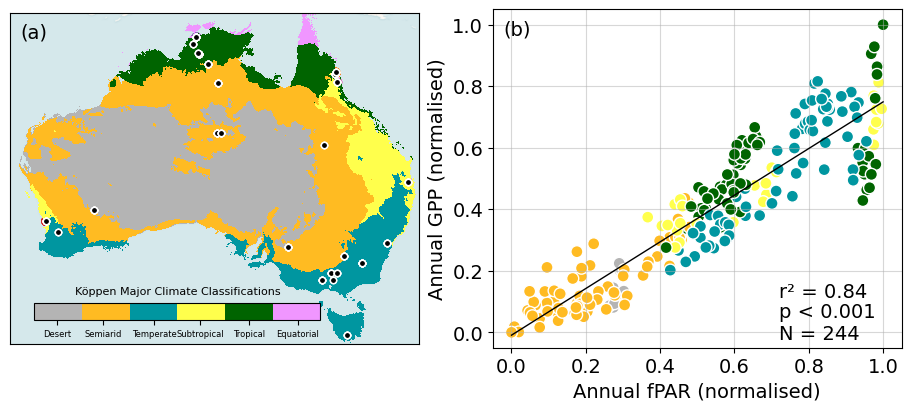

In [178]:
font=14
fig,ax = plt.subplots(1,2, figsize=(9,4), layout='constrained')

categories =['Desert', 'Semiarid', 'Temperate', 'Subtropical', 'Tropical', 'Equatorial']
colours = ['#b4b4b4',  '#ffbb22',   '#0096a0','#ffff4c',  '#006400'  ,   '#f096ff']
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colours, N=len(colours))

sites = gdf_ts[['site', 'latitude', 'longitude', 'geometry']]
aa = sites.plot(column='site', ax=ax[0])
# sites.apply(lambda x: aa.annotate(text=x['site'][0:5],
#             xy=x.geometry.centroid.coords[0],
#             ha='right', fontsize=8), axis=1);

im = koppen.plot(cmap=cmap, ax=ax[0], add_colorbar=False, add_labels=False)
aa = sites.plot(column='site', ax=ax[0],  color='k', markersize=20, marker='o', edgecolor='white')
ax[0].axes.get_xaxis().set_ticks([])
ax[0].axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

axins1 = inset_axes(ax[0],width="70%",height="5%",loc="lower left", borderpad=1.75)
cbar = fig.colorbar(im, cax=axins1, ticks=[50.4, 51.20, 52.1, 52.9, 53.75, 54.6], orientation='horizontal')
cbar.ax.set_title('Köppen Major Climate Classifications', fontsize=8);
cbar.ax.set_xticklabels(categories, fontsize=6);

varx='fPAR_normalised'
vary='GPP_normalised'

obs,pred = gdf_ts['fPAR'].values, gdf_ts['GPP_SOLO_EC'].values
mask = ~np.isnan(obs) & ~np.isnan(pred)
slope, intercept, r_value, p_value, std_err = stats.linregress(obs[mask],pred[mask])
r2 = r_value**2

sb.scatterplot(data=gdf_ts, y=vary, x=varx, s=75, lw=1, ax=ax[1], color=gdf_ts['hue']) 
sb.regplot(data=gdf_ts, y=vary, x=varx, scatter=False, color='black', line_kws={'linewidth':'1'}, ax=ax[1], ci=None)
ax[1].set_title(None)
ax[1].set_xlabel('Annual fPAR (normalised)', fontsize=font)
ax[1].set_ylabel('Annual GPP (normalised)',fontsize=font)
ax[1].grid(alpha=0.5)

ax[1].set_ylim(-0.05,1.05)
ax[1].set_xlim(-0.05,1.05)

ax[1].text(.70, .15, 'r\N{SUPERSCRIPT TWO} = {:.2f}'.format(r2),
        transform=ax[1].transAxes, fontsize=font)
ax[1].text(.70, .09, 'p < 0.001',
        transform=ax[1].transAxes, fontsize=font)
ax[1].text(.70, .025, 'N = {:.3g}'.format(len(gdf_ts)),
        transform=ax[1].transAxes, fontsize=font)
# ax.text(.4, .05, f'GPP = {slope:.1f}*NDVI{intercept:.2g}'.format(len(gdf_ts)),
#         transform=ax.transAxes, fontsize=font)
ax[1].tick_params(axis='x', labelsize=font)
ax[1].tick_params(axis='y', labelsize=font)

ax[0].text(0.025, 0.925, '(a)',  transform=ax[0].transAxes, fontsize=14)
ax[1].text(0.025, 0.925, '(b)',  transform=ax[1].transAxes, fontsize=14)  

fig.savefig('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/AnnualGPP_vs_annualfPAR.png',
               bbox_inches='tight', dpi=300)